In [28]:
from data_load import Rescale, RandomCrop, Normalize, ToTensor
from data_load import FacialKeypointsDataset
from torchvision import transforms, utils, models
from torch.utils.data import Dataset, DataLoader
from models import Net, Alexnet
import torch.nn.functional as F
import torch.nn as nn
import torch
import torchsnooper
import matplotlib.pyplot as plt
import numpy as np
# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
net = models.alexnet(pretrained=True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /home/houbowei/.cache/torch/checkpoints/alexnet-owt-4df8aa71.pth
100%|██████████| 233M/233M [05:47<00:00, 704kB/s]    


In [33]:
net.features[0] = nn.Conv2d(1, 64, kernel_size=(11, 11), stride=(4,4), padding=(2, 2))

In [35]:
net.classifier[6] = nn.Linear(4096, 68*2)

In [36]:
net

AlexNet(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [39]:
# one example conv layer has been provided for you
device = torch.device(2)
net = net.to(device)
print(net)
data_transform = transforms.Compose([
    Rescale(256),
    RandomCrop(224),
    Normalize(),
    ToTensor()
])
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='data/training_frames_keypoints.csv',
                                             root_dir='data/training/',
                                             transform=data_transform)
print('Number of images: ', len(transformed_dataset))
# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())
# load training data in batches
batch_size = 1024
train_loader = DataLoader(transformed_dataset,
                         batch_size=batch_size,
                         shuffle=True)
test_dataset = FacialKeypointsDataset(csv_file='data/test_frames_keypoints.csv',
                                            root_dir='data/test/',
                                            transform=data_transform)
test_loader = DataLoader(test_dataset,
                        batch_size=batch_size,
                        shuffle=True)

AlexNet(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [40]:
def net_sample_output():
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        # get sample data: images and ground truth keypoints
        images = sample['image'].to(device)
        print(images.size())
        key_pts = sample['keypoints'].to(device)
        # convert images to FloatTensors
        images = images.type(torch.cuda.FloatTensor)
        # forward pass to get net output
        output_pts = net(images)
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts

# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([770, 1, 224, 224])
torch.Size([770, 1, 224, 224])
torch.Size([770, 68, 2])
torch.Size([770, 68, 2])


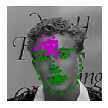

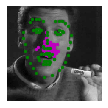

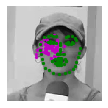

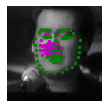

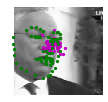

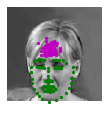

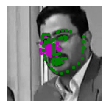

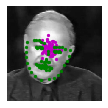

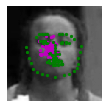

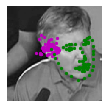

In [41]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0],
                predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')

# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(20, 10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's wrapper
        image = image.cpu().numpy()   # convert to numpy array from a Tensor
        # transpose to go from torch to numpy image
        image = np.transpose(image, (1, 2, 0))

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.cpu().numpy()
        # undo normalization of keypoints
        predicted_key_pts = predicted_key_pts*50.0+100

        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]
            ground_truth_pts = ground_truth_pts.cpu()*50.0+100

        # call show_all_keypoints
        show_all_keypoints(np.squeeze(
            image), predicted_key_pts, ground_truth_pts)

        plt.axis('off')

    plt.show()


# call it
visualize_output(test_images, test_outputs, gt_pts)

In [42]:
# TODO: Define the loss and optimization
import torch.optim as optim

criterion = torch.nn.MSELoss()

optimizer = optim.Adam(net.parameters())

In [43]:
def train_net(n_epochs):

    # prepare the net for training
    net.train()
    losses = []
    for epoch in range(n_epochs):  # loop over the dataset multiple times

        running_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image'].to(device)
            key_pts = data['keypoints'].to(device)

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.cuda.FloatTensor)
            images = images.type(torch.cuda.FloatTensor)
            
            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()

            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            # to convert loss into a scalar and add it to the running_loss, use .item()
            running_loss += loss.item()
            losses.append(loss.item())
            if batch_i % 99 == 0:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(
                    epoch + 1, batch_i+1, running_loss/100))
                running_loss = 0.0
    return losses

In [48]:
# train your network
n_epochs = 100 # start small, and increase when you've decided on your model structure and hyperparams
losses = train_net(n_epochs)

Epoch: 1, Batch: 1, Avg. Loss: 0.002104809731245041
Epoch: 2, Batch: 1, Avg. Loss: 0.0021819651126861574
Epoch: 3, Batch: 1, Avg. Loss: 0.0020245900750160218
Epoch: 4, Batch: 1, Avg. Loss: 0.0020773692429065706
Epoch: 5, Batch: 1, Avg. Loss: 0.0021631939709186553
Epoch: 6, Batch: 1, Avg. Loss: 0.0020594964921474457
Epoch: 7, Batch: 1, Avg. Loss: 0.0019004005193710327
Epoch: 8, Batch: 1, Avg. Loss: 0.0020504230260849
Epoch: 9, Batch: 1, Avg. Loss: 0.0020539245009422303
Epoch: 10, Batch: 1, Avg. Loss: 0.0020729300379753114
Epoch: 11, Batch: 1, Avg. Loss: 0.00186287522315979
Epoch: 12, Batch: 1, Avg. Loss: 0.0020651839673519134
Epoch: 13, Batch: 1, Avg. Loss: 0.0018993693590164185
Epoch: 14, Batch: 1, Avg. Loss: 0.0017045487463474274
Epoch: 15, Batch: 1, Avg. Loss: 0.00198050394654274
Epoch: 16, Batch: 1, Avg. Loss: 0.002104407548904419
Epoch: 17, Batch: 1, Avg. Loss: 0.0019081851840019226
Epoch: 18, Batch: 1, Avg. Loss: 0.001789516657590866
Epoch: 19, Batch: 1, Avg. Loss: 0.0020592936873

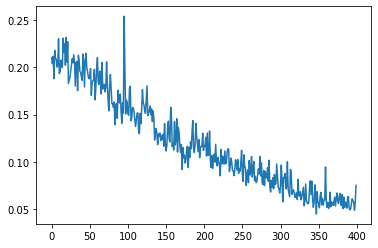

In [49]:
plt.plot(losses)

## Test data

See how your model performs on previously unseen, test data. We've already loaded and transformed this data, similar to the training data. Next, run your trained model on these images to see what kind of keypoints are produced. You should be able to see if your model is fitting each new face it sees, if the points are distributed randomly, or if the points have actually overfitted the training data and do not generalize.

In [50]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([770, 1, 224, 224])
torch.Size([770, 1, 224, 224])
torch.Size([770, 68, 2])
torch.Size([770, 68, 2])


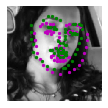

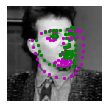

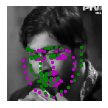

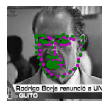

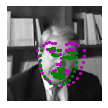

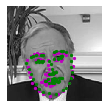

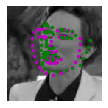

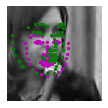

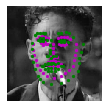

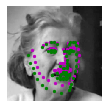

In [51]:
# TODO: visualize your test output
# you can use the same function as before, by un-commenting the line below:

visualize_output(test_images, test_outputs, gt_pts)

In [52]:
# TODO: change the name to something uniqe for each new model
model_dir = 'saved_models/'
model_name = 'keypoints_model_1.pt'

# after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)

**Answer**: (does it detect vertical lines or does it blur out noise, etc.) write your answer here

---
## Moving on!

Now that you've defined and trained your model (and saved the best model), you are ready to move on to the last notebook, which combines a face detector with your saved model to create a facial keypoint detection system that can predict the keypoints on *any* face in an image!